# Running the game output on real IBMQ machines

**In this notebook, we demonstrate how the output of the game can be ran on real quantum computers -- this helps to explain how the game really does solve the qubit routing problem. We will run a 10 qubit circuit and compare it to `qiskit`'s compilation approach.**

First we have some imports:

In [1]:
import sys, os; sys.path.append('..')

from game import Game
from util import get_backend_graphs, print_backend_info # useful functions
from qiskit import IBMQ

**Here we load our IBMQ account details. You can get your IBMQ_TOKEN by signing up to IBM's Quantum Experience here: [https://quantum-computing.ibm.com/](https://quantum-computing.ibm.com/)** 

You can either run

`IBMQ.save_account('IBMQ_TOKEN')`

followed by

`IBMQ.load_account('IBMQ_TOKEN')`,

or alternatively simply run

`IBMQ.enable_account('IBMQ_TOKEN')`

**Here we load our previously saved account data:** 

In [2]:
provider = IBMQ.load_account()

**Let's see which backends are available to us:**

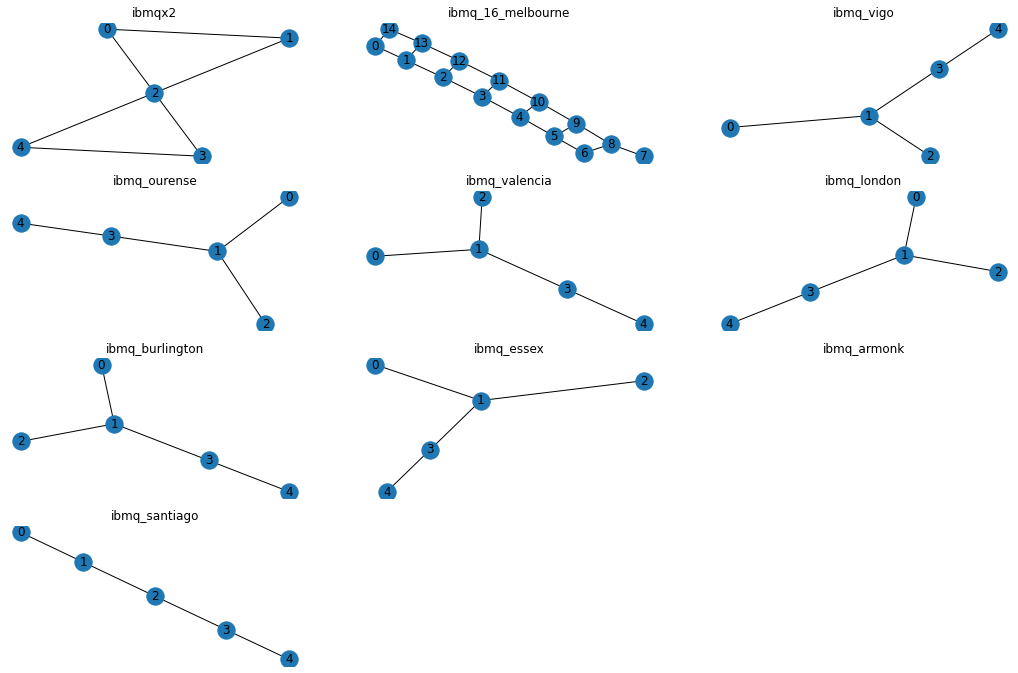

In [3]:
backend_graphs = get_backend_graphs(provider)

**Here are the queue details:**

In [4]:
print_backend_info(provider)

ibmqx2 :    5 qubits, 4 jobs in queue
ibmq_16_melbourne :    15 qubits, 5 jobs in queue
ibmq_vigo :    5 qubits, 8 jobs in queue
ibmq_ourense :    5 qubits, 45 jobs in queue
ibmq_valencia :    5 qubits, 1 jobs in queue
ibmq_london :    5 qubits, 40 jobs in queue
ibmq_burlington :    5 qubits, 0 jobs in queue
ibmq_essex :    5 qubits, 25 jobs in queue
ibmq_armonk :    1 qubits, 0 jobs in queue
ibmq_santiago :    5 qubits, 17 jobs in queue


**We will be using the 16 qubit melbourne machine in this notebook.**

In [5]:
backend_name = 'ibmq_16_melbourne'
backend = getattr(provider.backends, backend_name)
architecture = list(backend_graphs[backend_name].edges)

**These are the edges (valid CNOT connections) of our chosen architecture:**

In [6]:
print(architecture)

[(0, 1), (0, 14), (1, 2), (1, 13), (14, 13), (2, 3), (2, 12), (13, 12), (3, 4), (3, 11), (12, 11), (4, 5), (4, 10), (11, 10), (5, 6), (5, 9), (10, 9), (6, 8), (9, 8), (8, 7)]


**This will be our random circuit:**

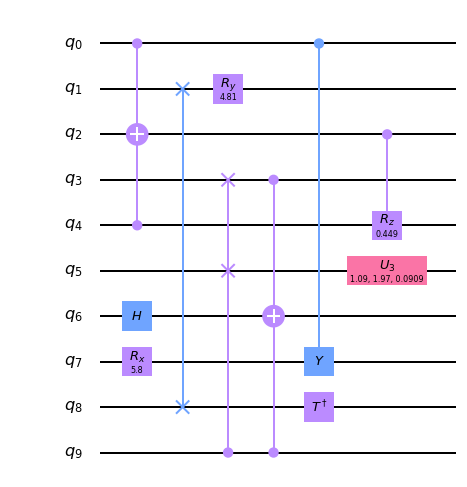

In [7]:
from qiskit.circuit.random import random_circuit
from qiskit import QuantumCircuit

circuit = random_circuit(num_qubits=10, depth=2, seed=123)
circuit.draw(output='mpl')

### Now we need to play the game to compile the circuit!

In [8]:
# for interactive plots
%matplotlib notebook 

<IPython.core.display.Javascript object>


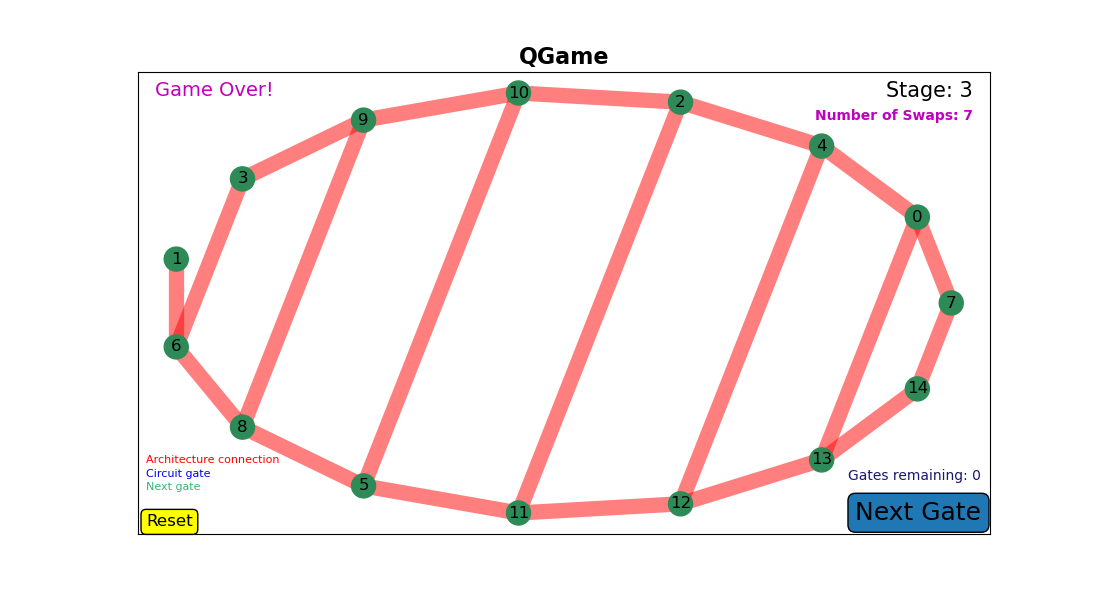

In [9]:
# here you can save the game output to a file
dir_name = 'output_data' # pass `None if you don't want to save it
filename = 'n=10 qubits' # pass `None if you don't want to save it
game = Game(circuit,architecture, output_dir=dir_name, output_filename=filename)

In [10]:
if game.stage==3: # game has finished
    initial_circuit = game.initial_circ
    final_circuit = game.final_circ
else:
    raise Exception('Finish the game first!')

**Here are the initial and final circuits, broken down into machine instructions:**

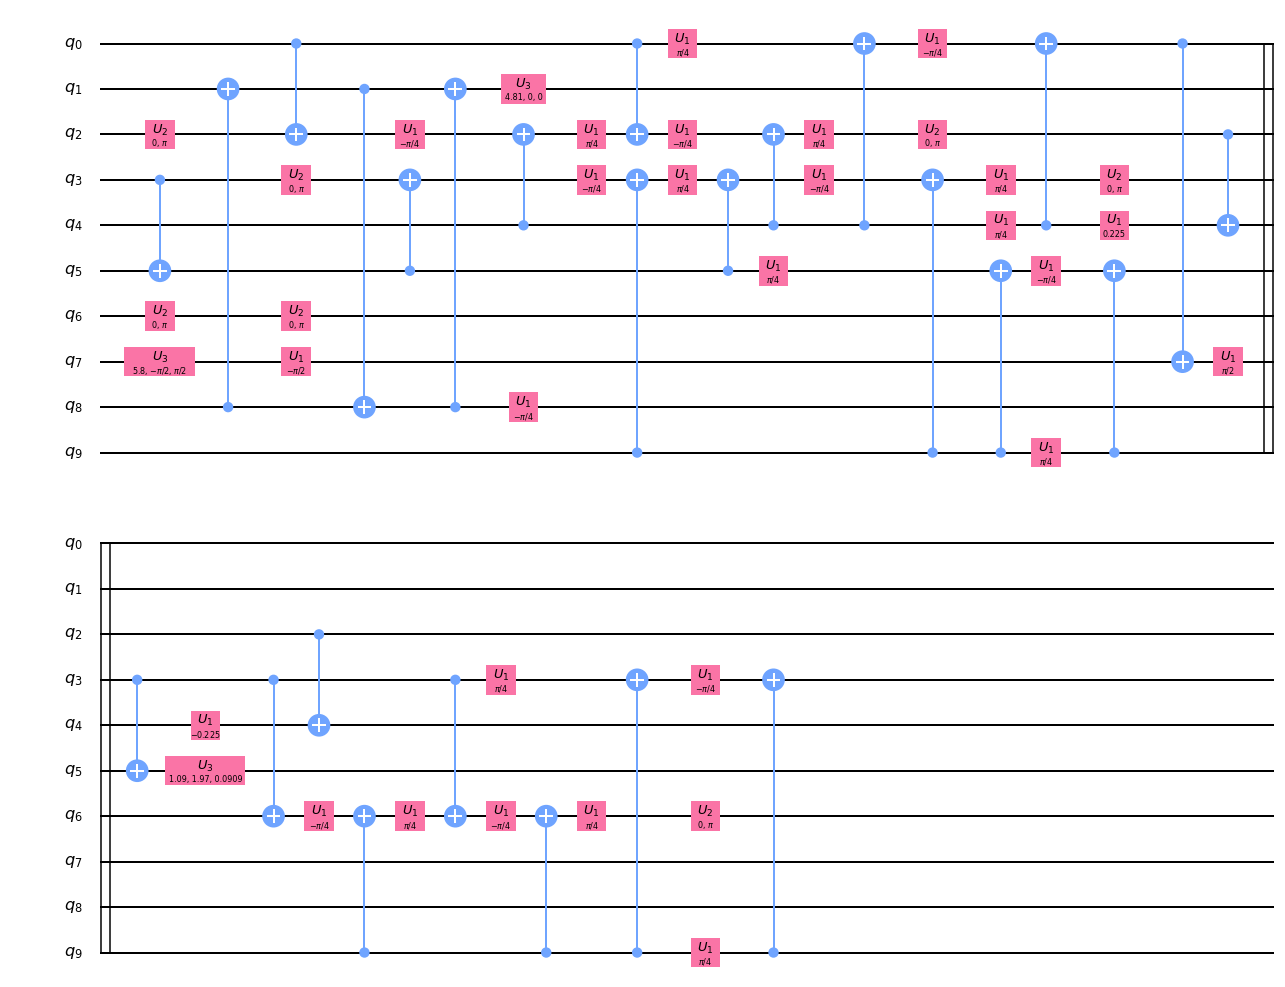

In [11]:
%matplotlib inline
initial_circuit.draw(output='mpl')

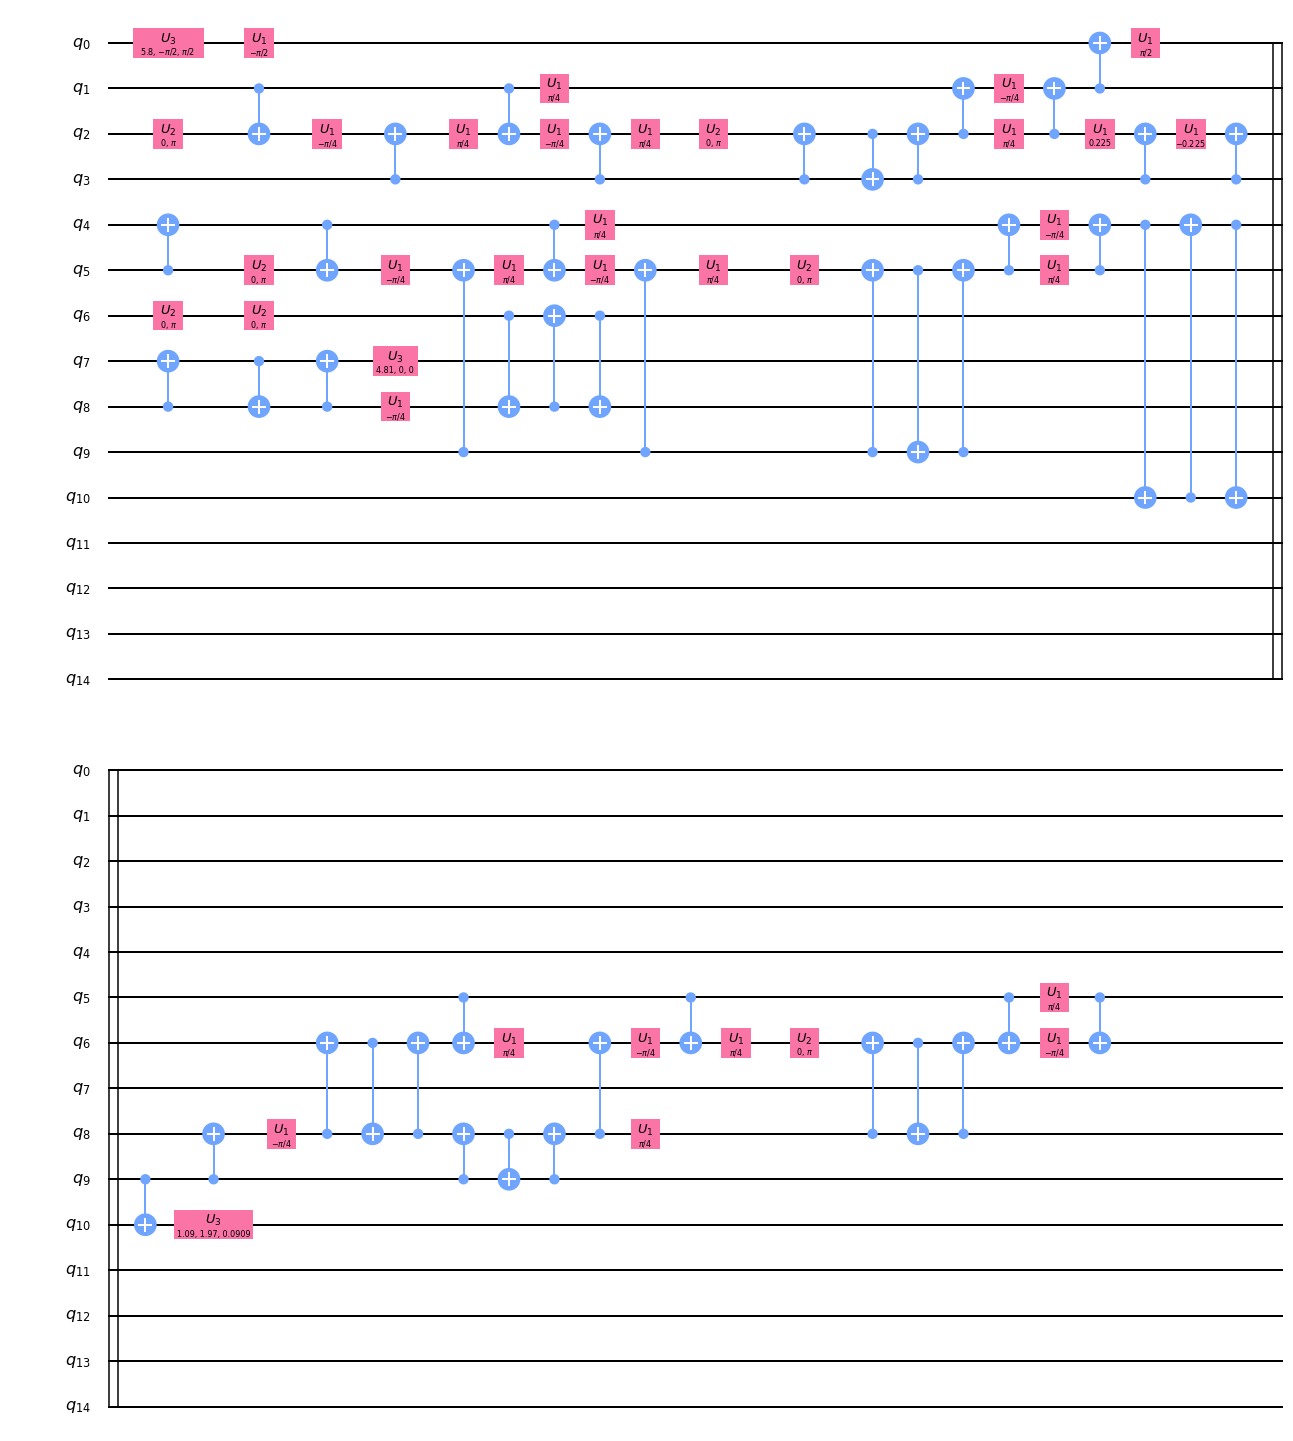

In [12]:
final_circuit.draw(output='mpl')

# Running on a real quantum computer and comparing the output

First we will get the exact probability distribution of the final state after the circuit, using the `statevector_simulator` backend from `qiskit.Aer`. Then we will run two circuits on a real quantum computer:
* The output circuit from the gameplay.
* The initial circuit via the `qiskit` way of compiling.

and compare the output distributions.

## Getting the Exact Distribution

In [13]:
from qiskit import Aer, execute
import math

We use the `statevector_simulator` to simulate the output state exactly.

In [14]:
state_vector_backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, state_vector_backend)
result = job.result()
output_state = result.get_statevector(circuit)

Now we use the output state to get a dictionary of the output probabilities of measuring each bitstring:

In [15]:
exact_probs = {}

for i in range(2**circuit.num_qubits):
    exact_probs[format(i, 'b').zfill(circuit.num_qubits)]= abs(output_state[i])**2

print('**Probabilities:**')
for k,v in exact_probs.items():
    if v != 0:
        print(k, ' : ', v)

**Probabilities:**
0000000000  :  0.18848862355849846
0000000010  :  0.15613504153774227
0000100000  :  0.06942627913864104
0000100010  :  0.057509438885357395
0001000000  :  0.18848862355849846
0001000010  :  0.15613504153774227
0001100000  :  0.06942627913864104
0001100010  :  0.057509438885357395
0010000000  :  0.011368096830879602
0010000010  :  0.009416792575513687
0010100000  :  0.004187227053577593
0010100010  :  0.0034685004197900237
0011000000  :  0.011368096830879602
0011000010  :  0.009416792575513687
0011100000  :  0.004187227053577593
0011100010  :  0.0034685004197900237


## Get the output from a real machine

In [17]:
from qiskit import assemble, transpile

**First we need to add measurements to the end of our circuits:**

In [18]:
circuit.measure_all()
final_circuit.measure_all()

### Now we can run the game output on the machine:

In [19]:
# we can directly assemble the circuit without transpiling
qobj = assemble(final_circuit, backend=backend)

# run the job
game_job = backend.run(qobj)
retrieved_game_job = backend.retrieve_job(game_job.job_id())

# get the counts
game_counts = retrieved_game_job.result().get_counts()

# fill in zero counts
for i in range(2**final_circuit.num_qubits):
    bin_string = format(i, 'b').zfill(final_circuit.num_qubits)
    if bin_string not in game_counts:
        game_counts[bin_string] = 0

# normalise the counts to probabilities
total_counts = sum(game_counts.values())
probs = {k: v / total_counts for k, v in game_counts.items()}

**We now need to relabel the output bitstrings to match the original circuit, as we have swapped and permuted the qubit order:**

In [39]:
# this takes a bitstring from the game output and returns the corresponding bitstring in the original circuit
def new_bitstring(b): 
    new_b = [0]*final_circuit.num_qubits

    for i in range(final_circuit.num_qubits):  
        new_b[i] = b[::-1][game.current_mapping(i)]  # we need the reverse b[::-1] to match the qiskit ordering

    return "".join(new_b[::-1]) # again we must reverse the bitstring


_game_probs = {new_bitstring(k):v for k,v in probs.items()}

**We also want to remove the additional ancilla qubits from the statistics here (we really ran a 10 qubit circuit on a 15 qubit machine).**

In [40]:
new_probs = {}

for k in _game_probs:
    
    new_k = k[5:] # remove the first 5 qubits
    if new_k not in new_probs:
        new_probs[new_k] = _game_probs[k]
    else:
        new_probs[new_k] += _game_probs[k]

game_probs=new_probs

### Now let's run the original circuit on the machine, using qiskit compilation:

First let's get the `qiskit` compiled circuit:

In [24]:
qiskit_circuit = transpile(circuit, backend=backend, seed_transpiler=0)

and compare the final numer of CNOTs with the game output:

In [25]:
num_qiskit_cnots = qiskit_circuit.count_ops()['cx']
num_game_cnots = final_circuit.count_ops()['cx']

print('qiskit CNOT count: ', num_qiskit_cnots)
print('game CNOT count: ', num_game_cnots)

qiskit CNOT count:  93
game CNOT count:  47


We see that our game has produced a compiled circuit with drastically fewer gates than the `qiskit` 'out-the-box' approach (nearly half!). This indicates that the statistics of the output circuit from playing the game will be close to the exact probabilities.

Let's run the `qiskit` circuit:

In [26]:
qobj = assemble(qiskit_circuit, backend=backend)
job = backend.run(qobj)
retrieved_job = backend.retrieve_job(job.job_id())
qiskit_counts = retrieved_job.result().get_counts()

# fill in zero counts
for i in range(2**qiskit_circuit.num_qubits):
    bin_string = format(i, 'b').zfill(qiskit_circuit.num_qubits)
    if bin_string not in qiskit_counts:
        qiskit_counts[bin_string] = 0

# renormalise the counts to probabilities
total_counts = sum(qiskit_counts.values())
qiskit_probs = {k: v / total_counts for k, v in qiskit_counts.items()}

## Plot the results

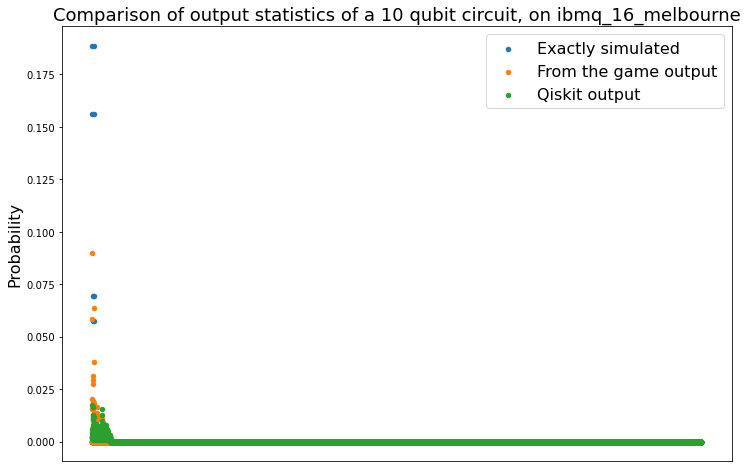

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.scatter(exact_probs.keys(), exact_probs.values(), label='Exactly simulated', s=20)
plt.scatter(game_probs.keys(), game_probs.values(), label='From the game output', s=20)
plt.scatter(qiskit_probs.keys(), qiskit_probs.values(), label='Qiskit output', s=20)

plt.ylabel('Probability', fontsize=16)

plt.title('Comparison of output statistics of a 10 qubit circuit, on {}'.format(backend_name), fontsize=18)

plt.xticks([], [])
plt.legend(fontsize=16)
plt.show()

**We can also only plot the non-zero probability outputs:**

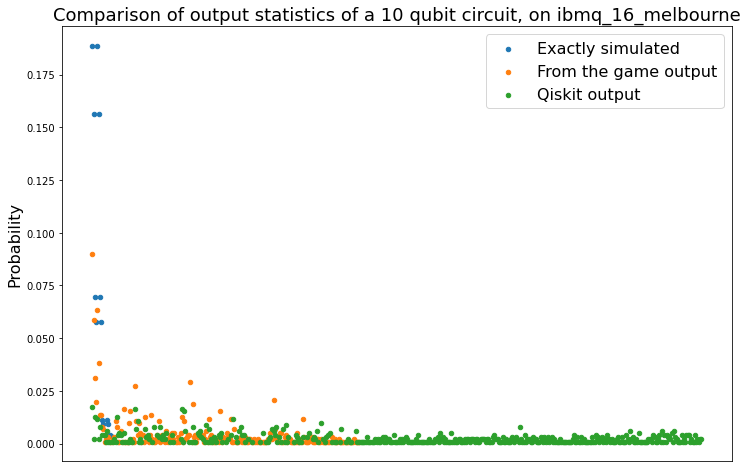

In [50]:
import matplotlib.pyplot as plt

nonzero_exact_probs = {k:v for k,v in exact_probs.items() if v!=0}
nonzero_game_probs = {k:v for k,v in game_probs.items() if v!=0}
nonzero_qiskit_probs = {k:v for k,v in qiskit_probs.items() if v!=0}

plt.figure(figsize=(12,8))
plt.scatter(nonzero_exact_probs.keys(), nonzero_exact_probs.values(), label='Exactly simulated', s=20)
plt.scatter(nonzero_game_probs.keys(), nonzero_game_probs.values(), label='From the game output', s=20)
plt.scatter(nonzero_qiskit_probs.keys(), nonzero_qiskit_probs.values(), label='Qiskit output', s=20)

plt.ylabel('Probability', fontsize=16)

plt.title('Comparison of output statistics of a 10 qubit circuit, on {}'.format(backend_name), fontsize=18)

plt.xticks([], [])
plt.legend(fontsize=16)
plt.show()

**We can also plot this on a log plot:**

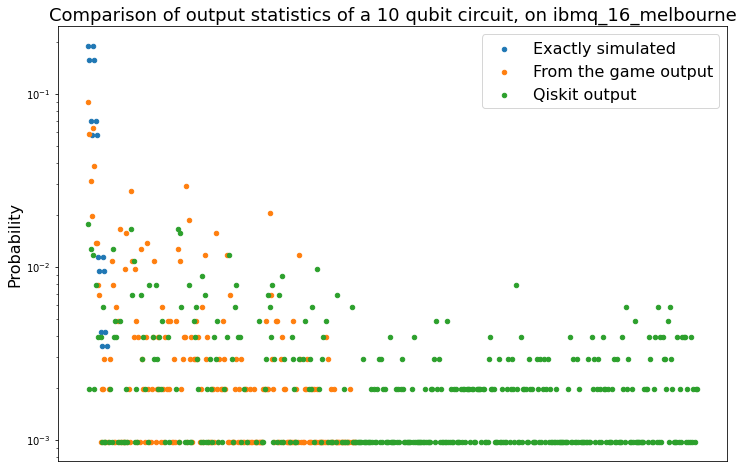

In [51]:
import matplotlib.pyplot as plt

nonzero_exact_probs = {k:v for k,v in exact_probs.items() if v!=0}
nonzero_game_probs = {k:v for k,v in game_probs.items() if v!=0}
nonzero_qiskit_probs = {k:v for k,v in qiskit_probs.items() if v!=0}

plt.figure(figsize=(12,8))
plt.scatter(nonzero_exact_probs.keys(), nonzero_exact_probs.values(), label='Exactly simulated', s=20)
plt.scatter(nonzero_game_probs.keys(), nonzero_game_probs.values(), label='From the game output', s=20)
plt.scatter(nonzero_qiskit_probs.keys(), nonzero_qiskit_probs.values(), label='Qiskit output', s=20)

plt.ylabel('Probability', fontsize=16)

plt.title('Comparison of output statistics of a 10 qubit circuit, on {}'.format(backend_name), fontsize=18)
plt.yscale('log')

plt.xticks([], [])
plt.legend(fontsize=16)
plt.show()

## Comparing the Kullback–Leibler divergence of the distributions

One natural way of comparing two probability distributions is the Kullback–Leibler divergence, see [here](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

It can be defined as

$$
D(p||q) = \sum_{x \in X} p(x) \log \bigg (\frac{p(x)}{q(x)} \bigg )
$$

where $p$ is considered the *reference* distribution to be compared against.

We can use this to compare our output distributions, using the exact probabilities as a reference. Note that the KL divergence is only define,d if $q(x)=0 \Rightarrow p(x)=0$, which may be reasonable in our case as if no counts were recorded then it is unlikely that the exact probability was non-zero unless our sample size is too small. However, noise in the machine could cause an otherwise zero probability count to occur.

Also note that $D(p||p)=0 $, so the lower the value $D(p||q)$ the closer we can interpret $p$ and $q$ as being.

In [55]:
def kullback_leibler(p,q):
    d = 0
    for i in p.keys():
        try:
            if q[i] == 0:
                if p[i]!=0:
                    print(ValueError('q = 0 must imply p = 0!')) # absolute continuity
            else:    
                if p[i]!=0:
                    d+= p[i]*math.log(p[i]/q[i])
        except KeyError:
            pass
    return d 

**Let's see how close the `qiskit` results are to the ideal probabilities, using this measure. Recall that lower is better!**

In [56]:
print('qiskit optimisation: ', kullback_leibler(exact_probs,qiskit_probs))

qiskit optimisation:  2.660328936774889


**and let's compare this with the game output statistics:**

In [57]:
print('game_output: ', kullback_leibler(exact_probs,game_probs))

q = 0 must imply p = 0!
game_output:  1.0835609837737938


### The game output statistics seem to reflect the true probabilities much better than the compiled `qiskit` circuits! This gives us reason to believe that by playing the game, we can on occasion compile the given circuit better than the current methods used in `qiskit`. 

### It would be interesting to understand why this may be the case, in order to shed more light on the qubit routing problem.